In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import networkx as nx 
import os 

from matplotlib.patches import FancyArrowPatch
from networkx.drawing.nx_pylab import draw_networkx_nodes, draw_networkx_labels

import torch
from torch.utils.data import DataLoader 
from sklearn.covariance import graphical_lasso 

In [2]:
project_dir = '../../'

os.chdir(project_dir)


In [3]:
from data_generation.graph import DirectedGraphGenerator 
from data_generation.structural_models import SEM
from data_generation.simulation_data import InterventionDataset

from models.helper.functions import gumbelSoftMLP, gnet_z
from models.nodags.resblock import iResBlock
from models.dccd.implicitblock import imBlock
from models.helper.layers.mlpLipschitz import linearLipschitz
from models.dccd.trainer_dccd import DCCDTrainer

from utils.plotting import draw_curved_edges
from utils.graph_transformations import *
from utils.error_metrics import *

In [5]:
# Experiment parameters - data

n_nodes = 5
exp_density = 2
n_samples = 1000

In [6]:
graph_gen = DirectedGraphGenerator(
    nodes=n_nodes, 
    expected_density=exp_density, 
    enforce_dag=False
)

graph = graph_gen()

In [7]:
sem = SEM(
    graph=graph,
    contractive=True,  
    confounders=True, 
    off_diag_nonzeros=2,
    noise_scale=0.5
)

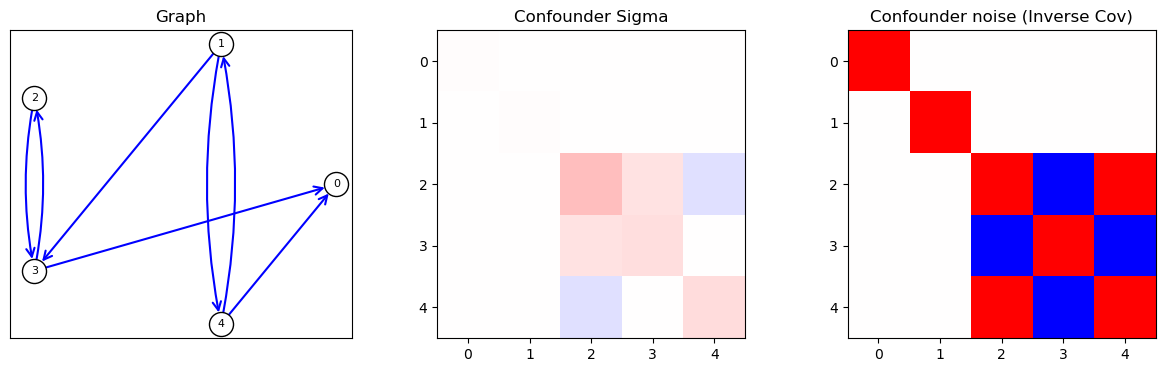

In [ ]:
fig, axs = plt.subplots(1, 3) 
fig.set_figwidth(15)
fig.set_figheight(4)

pos = nx.circular_layout(graph)

draw_networkx_nodes(graph, pos, ax=axs[0], node_size=300, node_color='white', edgecolors='black')
draw_networkx_labels(graph, pos, ax=axs[0], font_size=8, font_color="black")
draw_curved_edges(graph, pos, axs[0], curve_scale=0.1, node_size=300)

_ = axs[1].imshow(sem.confounder_sigma, cmap='bwr', vmin=-1, vmax=1)

_ = axs[2].imshow(sem.confounder_inverse_cov, cmap='bwr', vmin=-5, vmax=5)

axs[0].set_title("Graph")
axs[1].set_title("Confounder Sigma")
_ = axs[2].set_title("Confounder noise (Inverse Cov)")

In [9]:
n_inter = 5
intervention_sets = [[None]] + [[i] for i in range(n_inter)]

datasets = list()
intervention_torch_datasets = list()
for targets in intervention_sets:
    data = sem.generateData(n_samples=n_samples, intervention_set=targets)
    datasets.append(data)

    intervention_torch_datasets.append(
        InterventionDataset(data, targets)
    )

In [10]:
g_x = gumbelSoftMLP(
    n_nodes = n_nodes, 
    lip_constant=0.9, 
    activation='tanh'
)

g_z = gnet_z(
    n_nodes=n_nodes
)

In [11]:
implicit_block = imBlock(
    nnet_x=g_x, 
    nnet_z=g_z,
    confounders=True
)

In [12]:
im_trainer = DCCDTrainer(
    implicit_block, 
    max_epochs=200, 
    batch_size=512, 
    lr=1e-1,
    lambda_c=1e-3, 
    rho=1e-2
)

In [13]:
im_trainer.train(
    intervention_datasets=datasets,
    intervention_targets=intervention_sets,
    verbose=True
)

Epoch: 200/200, Intervention: 6/6, log P(X): 1.58


Text(0.5, 1.0, 'Estimated')

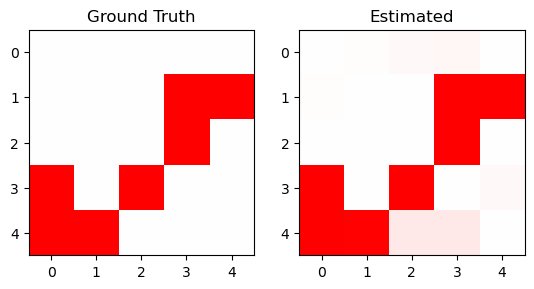

In [16]:
fig, axs = plt.subplots(1, 2)

axs[0].imshow(np.abs(sem.weights) > 0, cmap='bwr', vmin=-1, vmax=1)
axs[0].set_title("Ground Truth")

axs[1].imshow(g_x.get_w_adj().detach().cpu().numpy(), cmap='bwr', vmin=-1, vmax=1)
axs[1].set_title("Estimated")

Text(0.5, 1.0, 'Estimated')

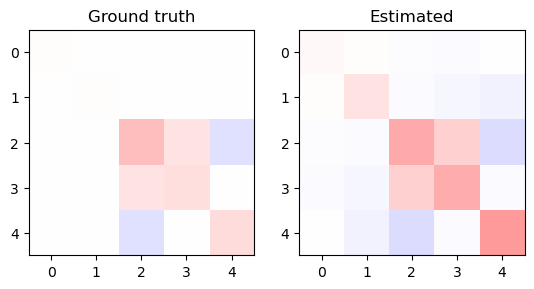

In [17]:
fig, axs = plt.subplots(1, 2)

axs[0].imshow(sem.confounder_sigma, cmap='bwr', vmin=-1, vmax=1)
axs[0].set_title("Ground truth")

axs[1].imshow(implicit_block.cov_mat.detach().cpu().numpy(), cmap='bwr', vmin=-1, vmax=1)
axs[1].set_title("Estimated")